In [1]:
##packages to load
library(tm)
library(SnowballC)
library(ggplot2)
library(lsa)
library(cluster)
library(proxy)
library(wordcloud)
library(MASS)
library(svs)
library(topicmodels)
library(igraph)
library(ldatuning)

Loading required package: NLP

Attaching package: 'ggplot2'

The following object is masked from 'package:NLP':

    annotate


Attaching package: 'proxy'

The following objects are masked from 'package:stats':

    as.dist, dist

The following object is masked from 'package:base':

    as.matrix

Loading required package: RColorBrewer

Attaching package: 'svs'

The following objects are masked from 'package:lsa':

    gw_gfidf, gw_idf, lw_tf


Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union



There are many instances recorded with no lyrics provided at all.We remove all such cases and thus form the working data-set.Further we remove all the instances with genre "not-available".Now,as mentioned we perform a stratified sampling,stratas being the genres and the sampling is done to ensure enough representation from each genre where sampling size of each genre is chosen randomly in between 80 and 120.

In [2]:
##lyrics data reading
lyrics_data_all = read.csv("lyrics.csv",stringsAsFactors = F)

#omitting those with no lyrics
to_omit=which(lyrics_data_all$lyrics=="")

#working full data set
lyrics_data_all=lyrics_data_all[setdiff(1:339277,to_omit),]

##omitting instances with genre not available
to_omit=which(lyrics_data_all$genre=="Not Available")
lyrics_data_all=lyrics_data_all[setdiff(1:dim(lyrics_data_all)[1],to_omit),]

##stratified sampling
n=dim(lyrics_data_all)[1] ##no of lyrics we will take 
genre_names=names(table(lyrics_data_all$genre))
genre_size=as.numeric(table(lyrics_data_all$genre))
subset=numeric(0)
sampling_sizes=numeric(length(genre_names))
for (j in 1:length(genre_names)){
  sampling_set=lyrics_data_all[lyrics_data_all$genre==genre_names[j],]
  sampling_sizes[j]=sample(80:120,1) #change this according to the size of data
  subset=rbind(subset,sampling_set[sample(1:genre_size[j],sampling_sizes[j],rep=F),])
}
lyrics_data=subset

#str(text_data)
colnames(lyrics_data)=c("doc_id",names(lyrics_data)[2:5],"text")
df=as.data.frame(lyrics_data)

##for aaplying the code on kobita data comment above part and uncomment the below lines
#kobita_data
#df=as.data.frame(read.csv("C:/Users/lenovo/Downloads/Kobita_Data/kobita_and_porjaay.csv",header = T))
#colnames(df)=c("doc_id","text","genre")


Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
"EOF within quoted string"

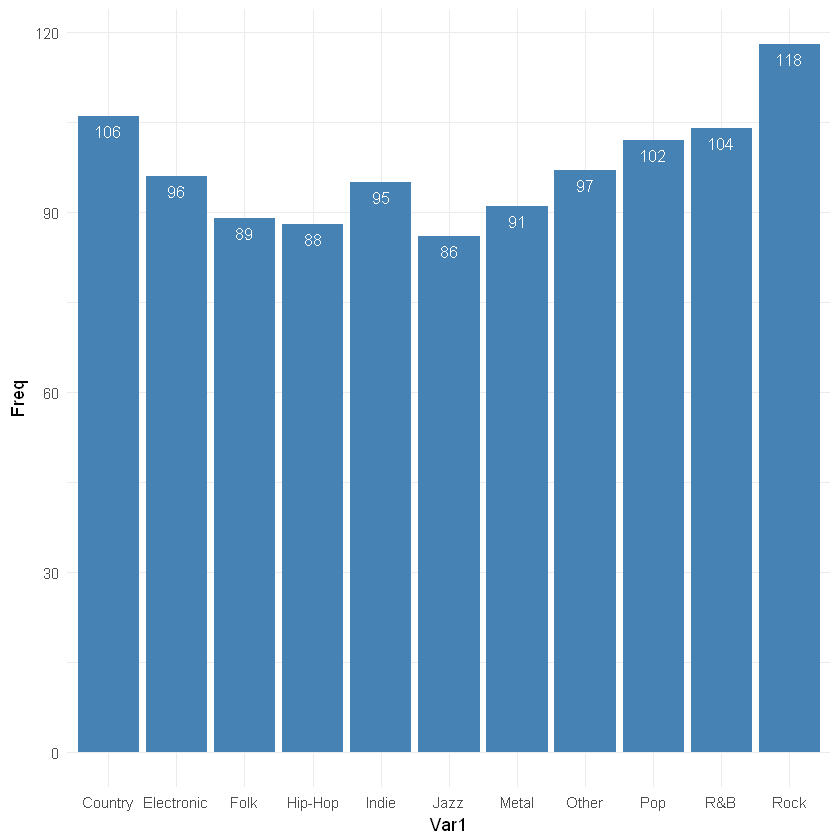

In [3]:
#plotting representations of each genres in the data
to.plot=as.data.frame(table(df$genre))
ggplot(data=to.plot, aes(x=Var1, y=Freq)) +
  geom_bar(stat="identity", fill="steelblue")+
  geom_text(aes(label=Freq), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

In [4]:
#replacing \n with white spaces
df$text=gsub("[\r\n]", " ", df$text)

##making the corpus
df_source=DataframeSource(lyrics_data)
df_corpus = VCorpus(df_source)
print(df_corpus)

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 4
Content:  documents: 1072


In [5]:
##pre-processing steps
clean_corpus <- function(corpus) {
  # Remove punctuation
  corpus <- tm_map(corpus, removePunctuation)
  #removing numbers
  corpus <- tm_map(corpus, removeNumbers)
  # Transform to lower case
  corpus <- tm_map(corpus, content_transformer(tolower))
  # Add more stopwords
  corpus <- tm_map(corpus, removeWords, c(stopwords("en")))
  # Strip whitespace
  corpus <- tm_map(corpus, stripWhitespace)
  #stemming (can ignore for now)
  #corpus <- tm_map(corpus, stemDocument, language = "english")
  return(corpus)
}
cleaned_corpus=clean_corpus(df_corpus)
cleaned_corpus

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 4
Content:  documents: 1072

CountryElectronic

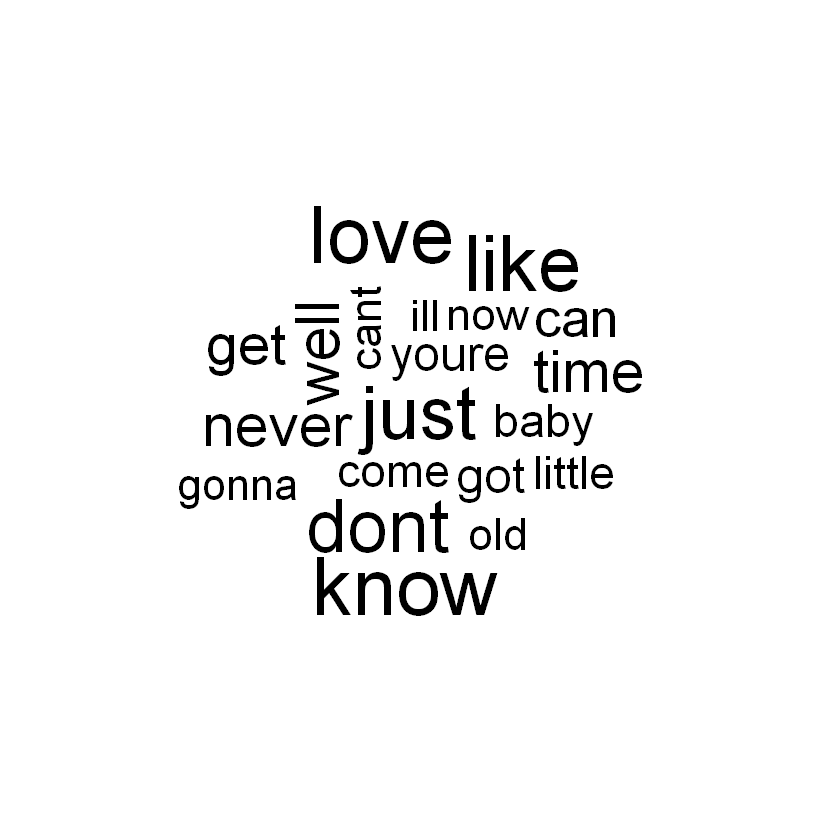

Folk

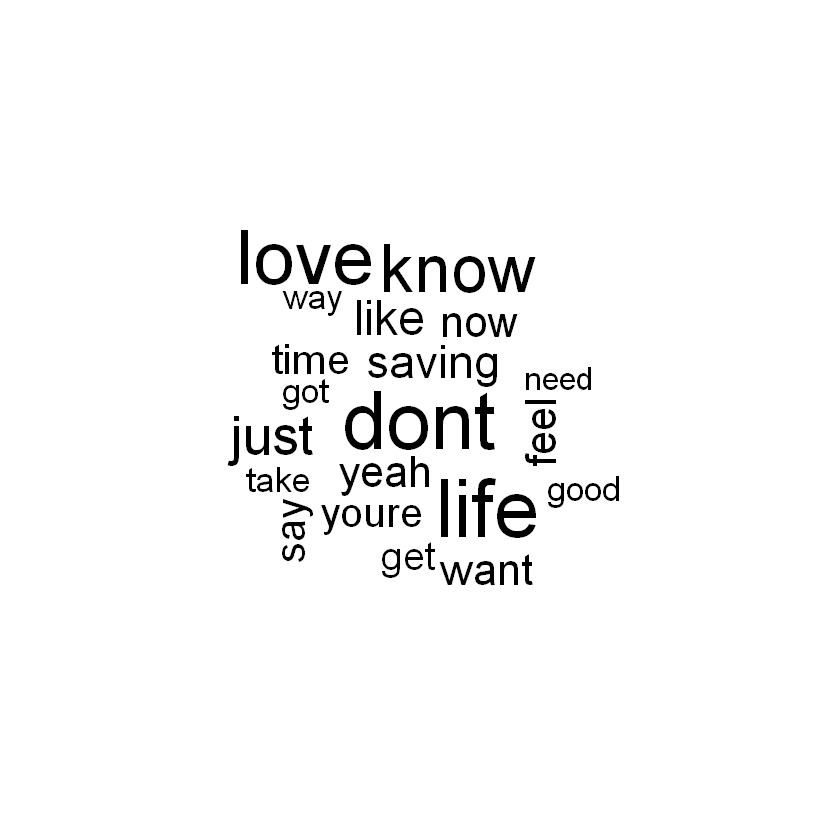

Hip-Hop

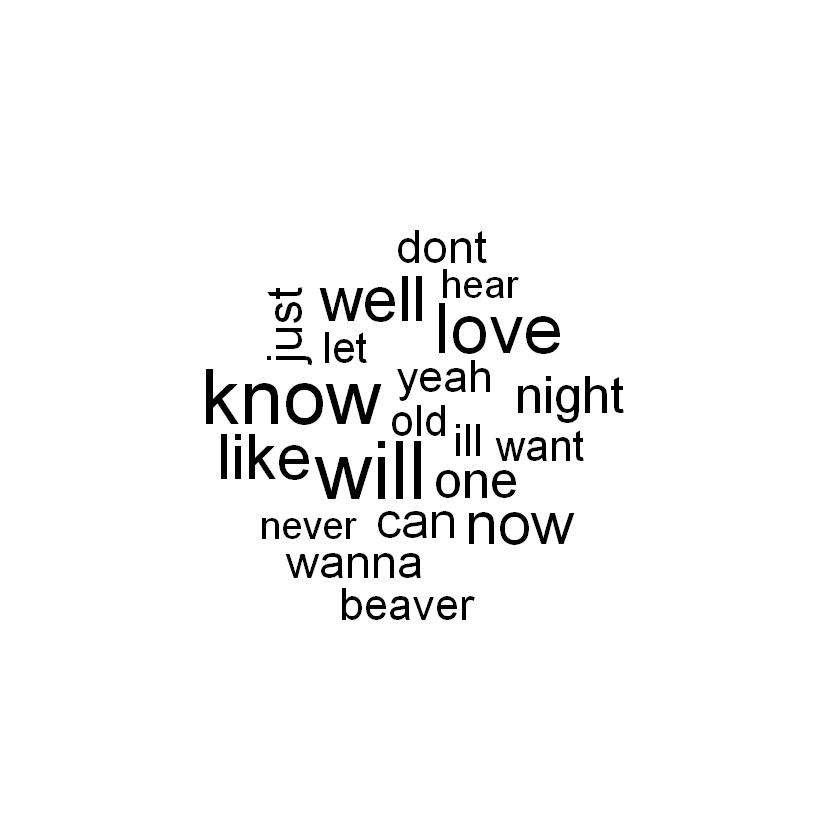

Indie

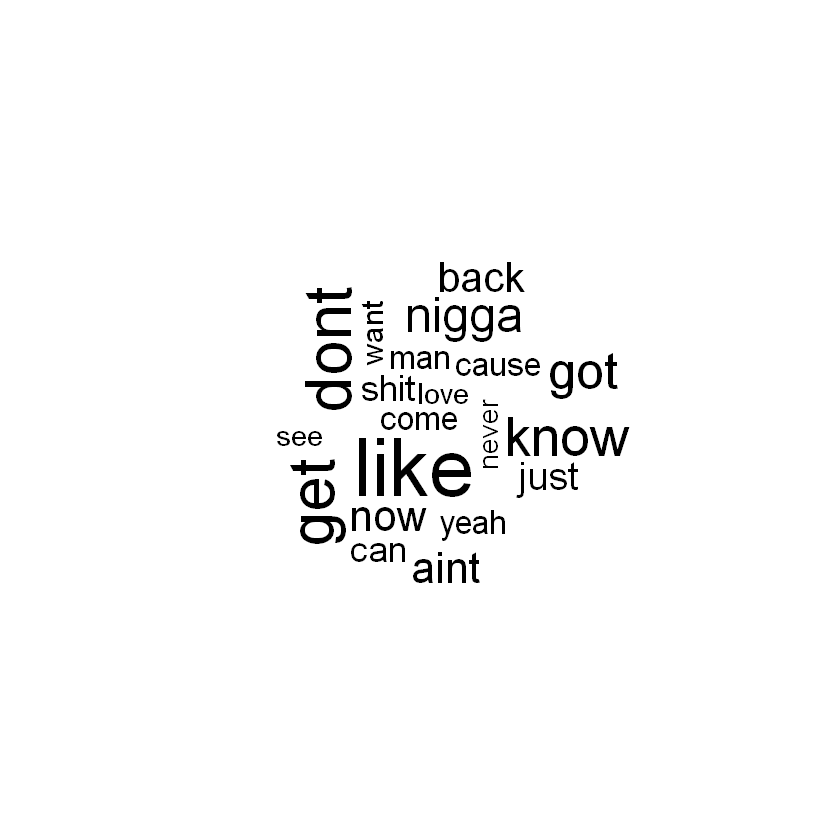

Jazz

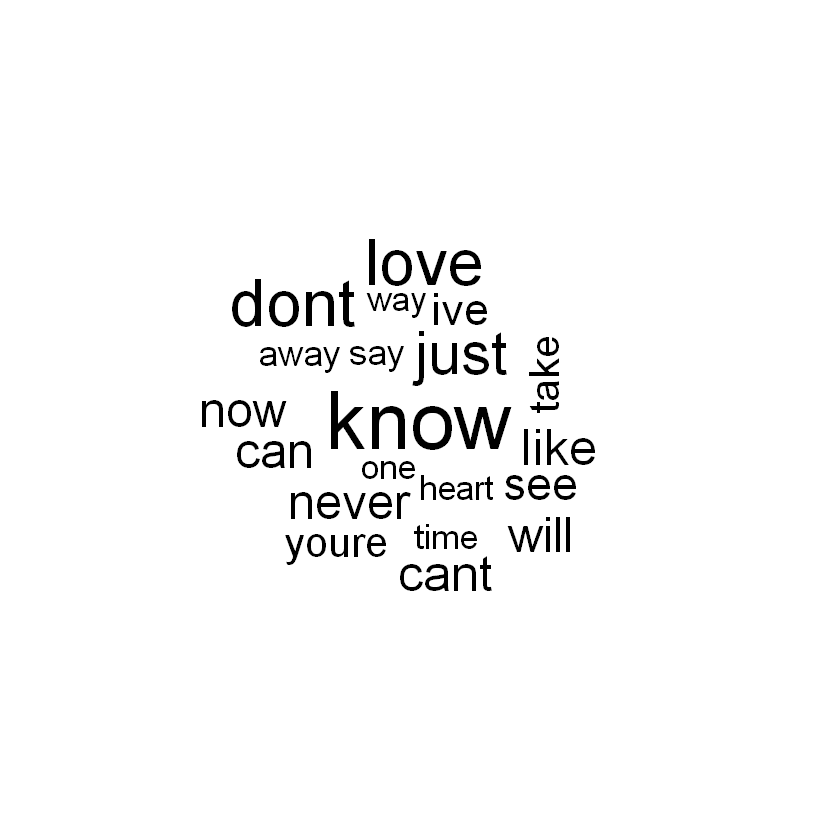

Metal

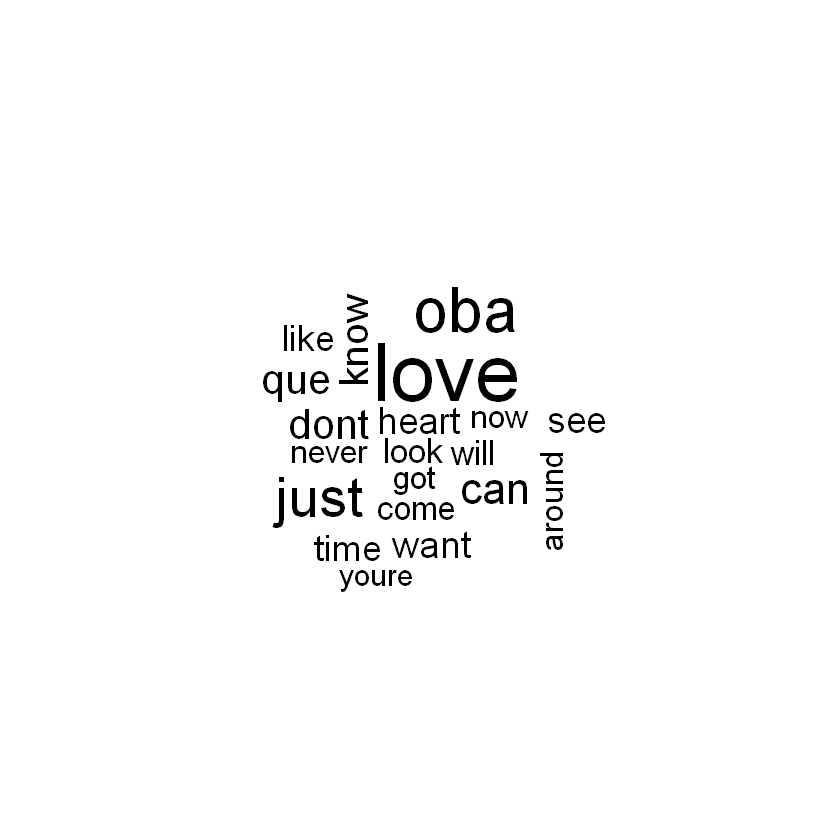

Other

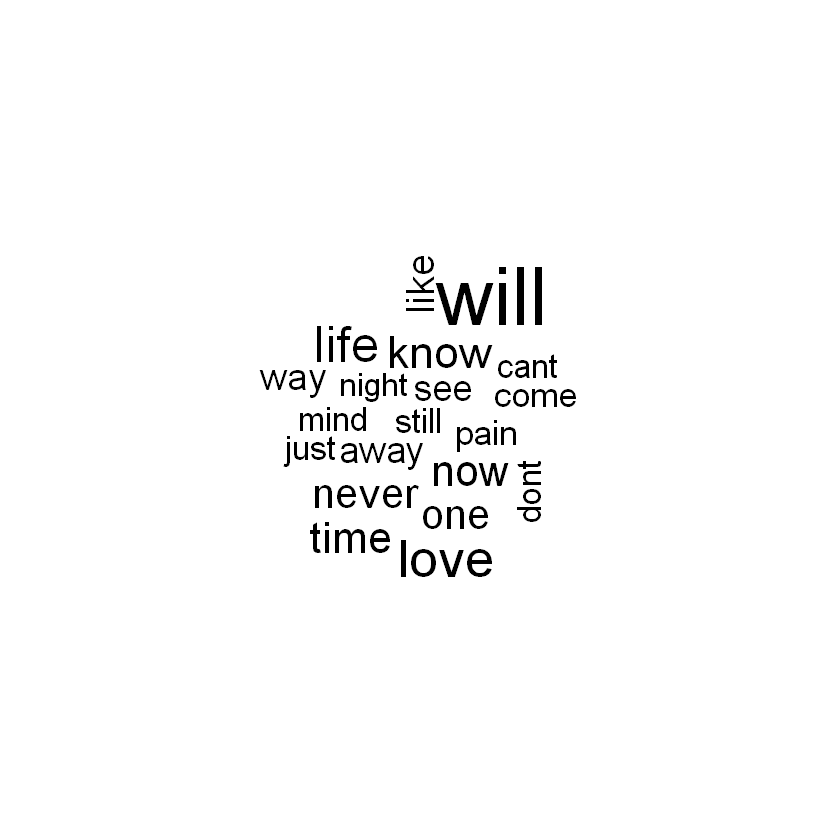

Pop

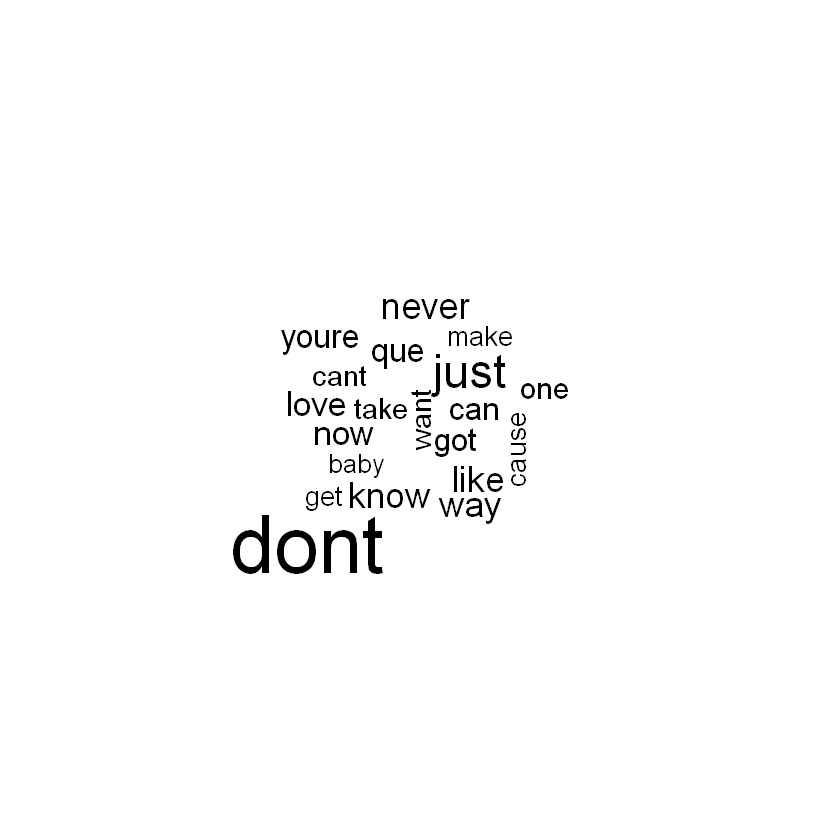

R&B

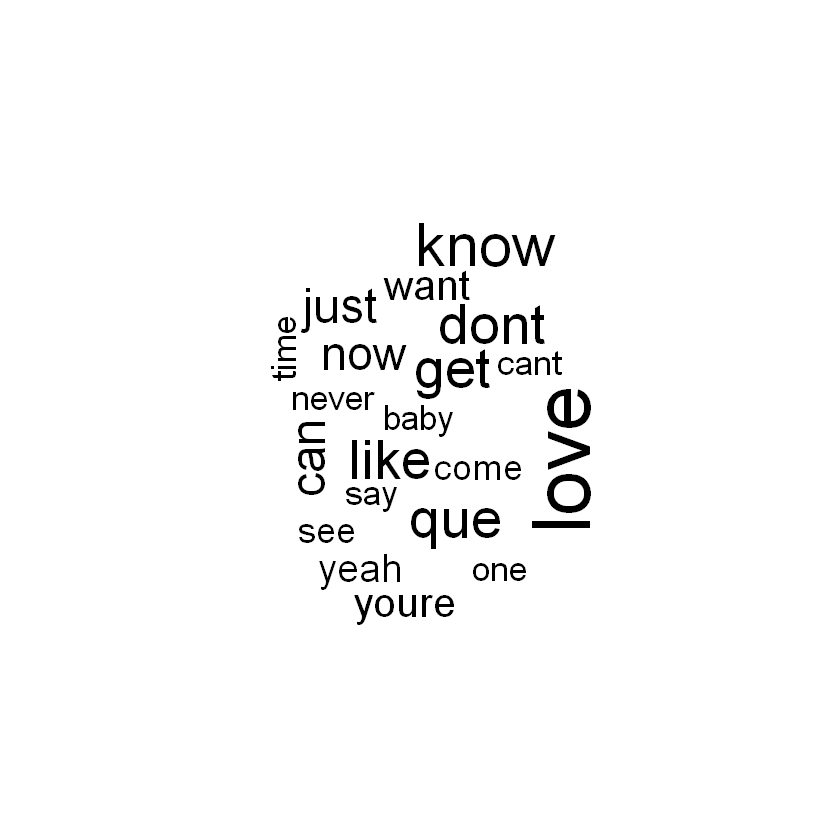

Rock

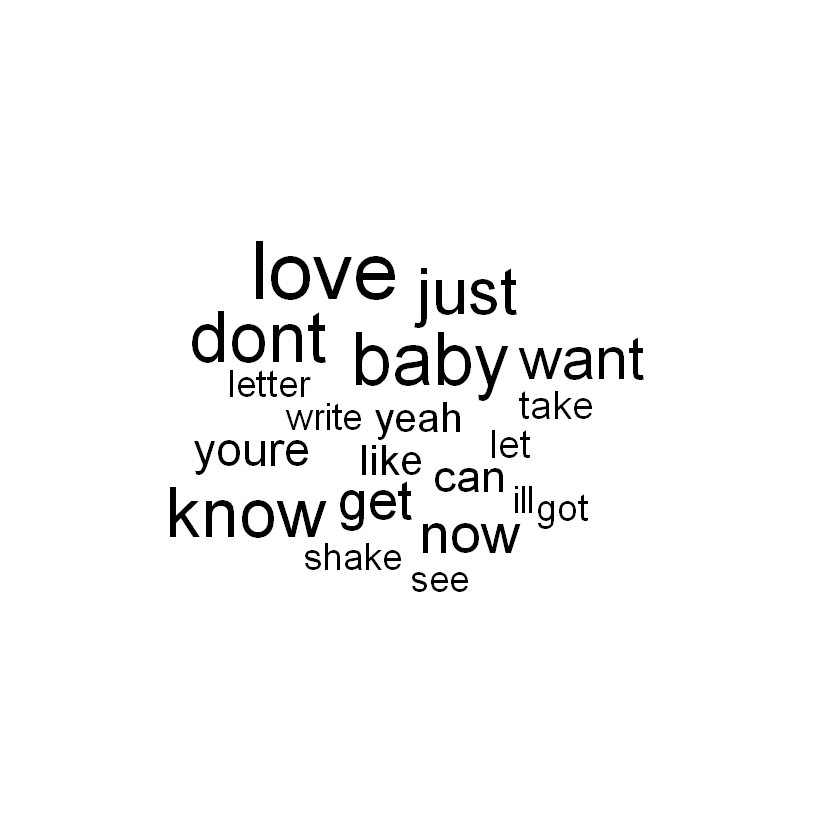

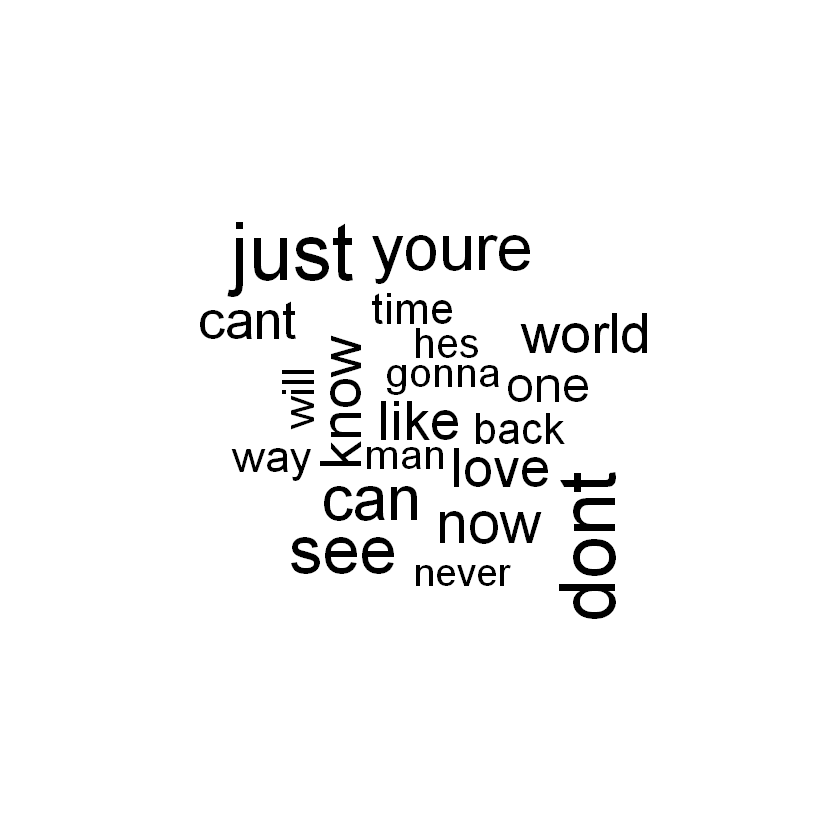

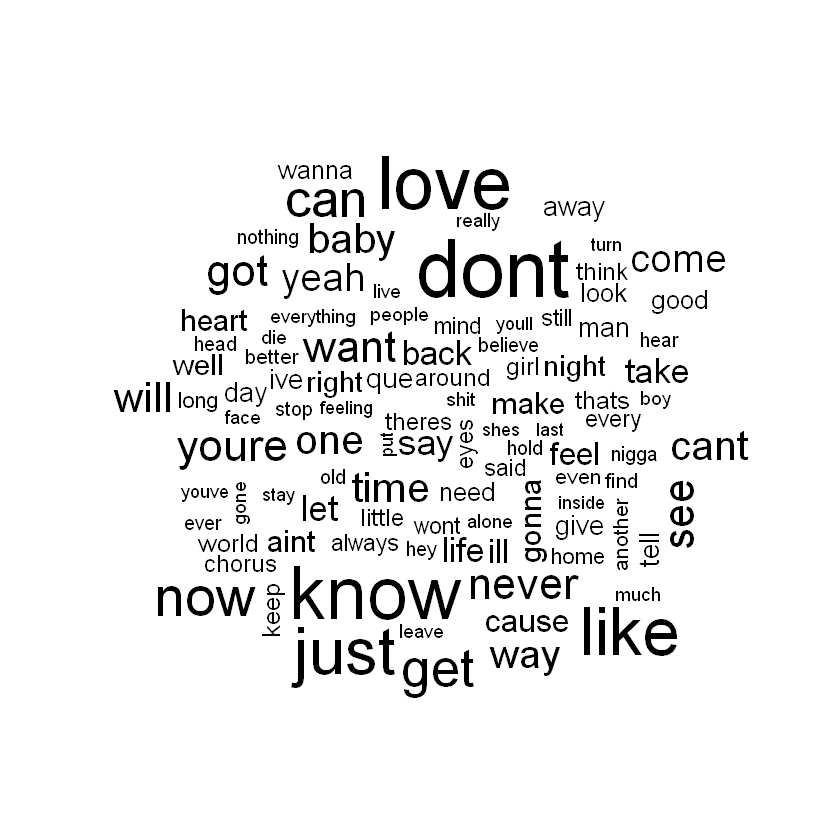

In [6]:
##genre wise wordcloud
for(id in unique(df$genre)){
  cat(id)
  dummy_df=df[df$genre==id,]
  dummy_df_corpus=VCorpus(DataframeSource(dummy_df))
  dummy_df_corpus=clean_corpus(dummy_df_corpus)
  wordcloud(dummy_df_corpus,max.words = 20)
}

#save(cleaned_corpus,file = "lyrics_corpus.rds")
#load("lyrics_corpus.rds")

#pictorial visualisation of important words
wordcloud(cleaned_corpus,max.words = 100)

In [7]:
#term document matrix
initial_td.mat<-TermDocumentMatrix(cleaned_corpus)

#removing empty documents after all the preprocessing
col_totals=apply(initial_td.mat,2,sum)
initial_td.mat=initial_td.mat[,col_totals>0]

#document_term_matrix
initial_dt.mat=DocumentTermMatrix(cleaned_corpus)

#removing empty documents
row_totals=apply(initial_dt.mat,1,sum)
to.omit=which(row_totals==0)
initial_dt.mat=initial_dt.mat[row_totals>0,]

#updating the data frame to work with
if(length(to.omit)!=0){
df=df[-(to.omit),]
}

#Term document matrix based on Tf-idf weighting
initial_td.mat.tfidf<-as.matrix(weightTfIdf(initial_td.mat))

In [8]:
##latent semantic analysis
lsa_space=lsa(initial_td.mat.tfidf,dims=100)
doc_vec=as.matrix(lsa_space$dk)

#cosine distance between feature vectors
dist.mat.tfidf <- dist((as.matrix(doc_vec)),method = "cosine")
dist.mat.tfidf  # check distance matrix

Warning message in lsa(initial_td.mat.tfidf, dims = 100):
"[lsa] - there are singular values which are zero."

            121685      211734       68331      134184      139528        3925
211734 0.824720170                                                            
68331  0.838811334 0.832890834                                                
134184 0.744997946 0.981093709 0.906826099                                    
139528 0.995967083 0.995198694 0.995130995 0.934876361                        
3925   0.802588395 0.698560058 0.923949653 0.894753034 0.973099573            
95153  0.596616491 0.955101422 0.989502405 0.820111861 0.993074347 0.909357938
68088  0.339443700 0.784692911 0.724436804 0.662010405 0.987373367 0.788697828
129592 0.695583537 0.724226614 0.992581985 0.948711200 0.991848918 0.613317310
176372 0.914853234 0.990150825 0.849295428 0.991292550 0.997101215 0.882497858
29653  0.921994664 0.949555024 0.945587033 0.909897664 0.990147552 0.992836767
216786 0.758001397 0.675722608 0.708452681 0.957885091 0.975894446 0.969278142
34570  0.969216819 0.844265206 0.917194120 0.9578384

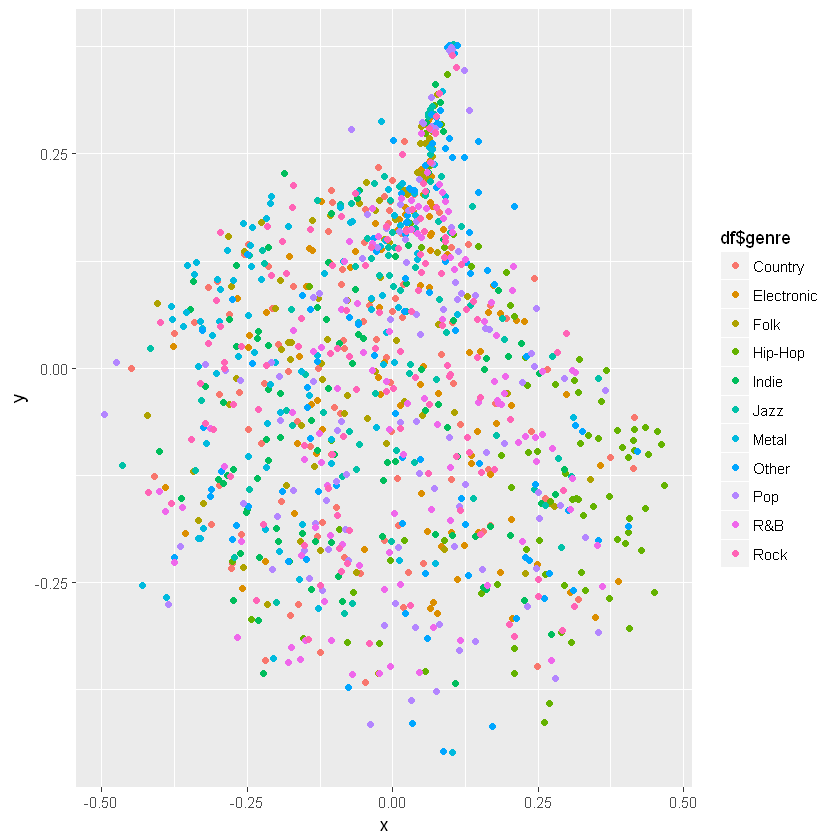

In [9]:
##original points with 2-D representation
#Multi-dimensional Scaling
fit <- cmdscale(dist.mat.tfidf, eig = TRUE, k = 2)
points <- data.frame(x = fit$points[, 1], y = fit$points[, 2])
ggplot(points, aes(x = x, y = y),color=df$genre) + geom_point(data = points, aes(x = x, y = y,color = df$genre)) 


  1   2   3   4   5   6   7   8   9  10  11 
 81 166  58 163  93  86 106  54  78  98  88 

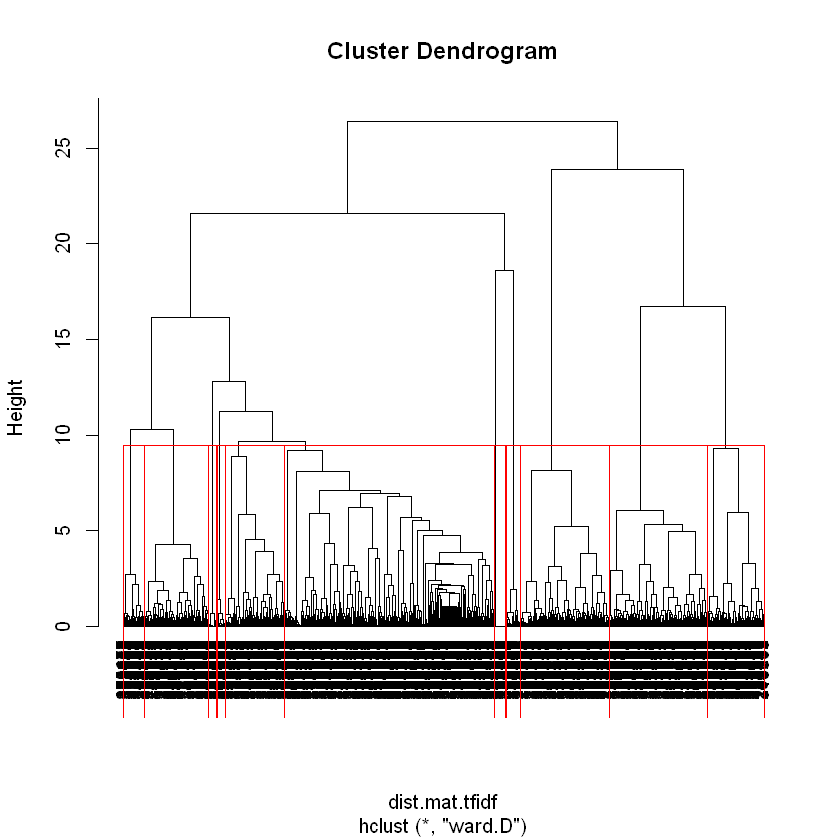

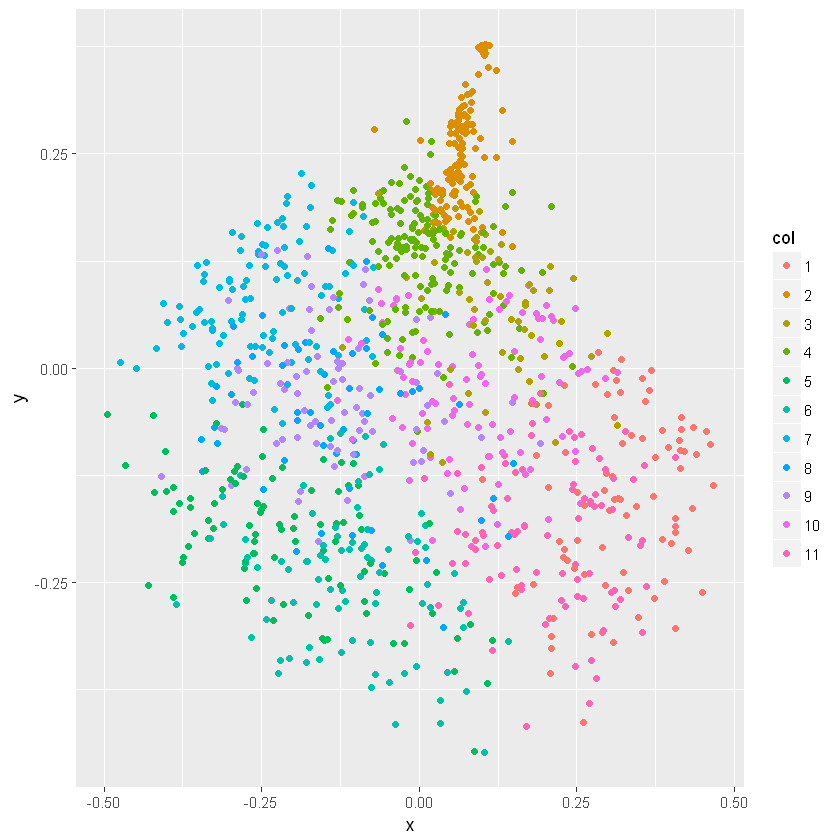

In [10]:
#no of actual genres in the data we are using
k=length(unique(df$genre))

#clustering(hierarchical) using tf_idf value
groups <- hclust(dist.mat.tfidf,method="ward.D")
plot(groups, cex=0.9, hang=-1)

#visualisation of clusters
rect.hclust(groups, k)

#clustering (k means) using tf_idf values
cluster<-kmeans(dist.mat.tfidf,k)
#cluster #inspection of cluster

table(cluster$cluster)

#visualisation of clusters using first 2 principal components
col=as.factor(cluster$cluster)
ggplot(points,aes(x = x, y = y,color=col)) + geom_point(data = points, aes(x = x, y = y,color = col)) 

[1] 22540.24 17928.34 15995.33 14940.61 13816.17 13471.82 12854.34 12793.49
 [9] 12365.84 12080.08 11846.06 11667.54 11410.64 11280.99 11017.52

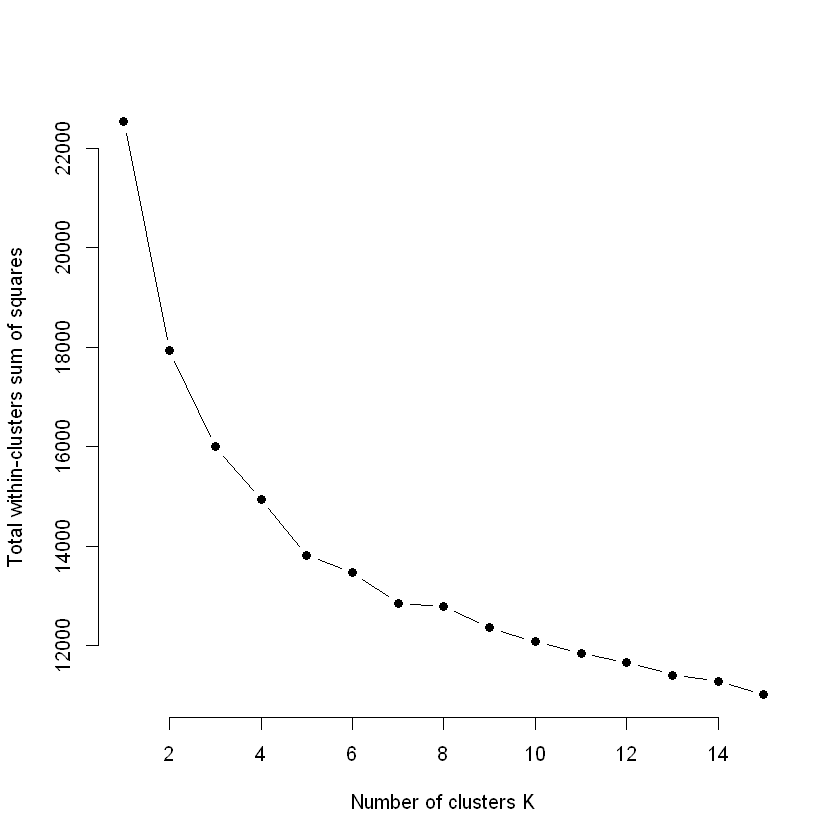

In [11]:
#elbow methhod for optimal k choice
k.max <- 15
wss <- sapply(1:k.max, 
              function(k){kmeans(dist.mat.tfidf, k)$tot.withinss})
wss
plot(1:k.max, wss,
     type="b", pch = 19, frame = FALSE, 
     xlab="Number of clusters K",
     ylab="Total within-clusters sum of squares")

In [12]:
#lda_model with no of topics=no of genres
model_lda=LDA(initial_dt.mat,k,method = "Gibbs",control = list(iter=1000,seed=33))

#matrix containing P(z|d) z being topic,d being documents
theta_topic=posterior(model_lda)$topics

#prediction of category of the documents with maximum posterior probability
pred_category=apply(theta_topic,1,function(x) as.numeric(which.max(x)))

#category wise mean theta
theta_topic_by=by(theta_topic,df$genre,colMeans)
theta_means=do.call("rbind",theta_topic_by)

In [13]:
##LDA K means with symmetrized KL divergence and one-column out k means
model_lda=LDA(initial_dt.mat,25,method = "Gibbs",control = list(iter=1000,seed=33))

#matrix containing P(z|d) z being topic,d being documents
theta_topic=posterior(model_lda)$topics

In [14]:
obs_no=nrow(df)
#Jensen-Shannon Divergence
FUN = function(i,j) {
  p=theta_topic[i,]
  q=theta_topic[j,]
  m=0.5*(p+q)
  JS <- 0.5 * (sum(p * log(p / m)) + sum(q * log(q / m)))
  return(JS)
}

In [15]:
#distance measures
dist_lda_1=outer(1:obs_no,1:obs_no,Vectorize(FUN))
dist_lda_2=dist(as.matrix(theta_topic[,-1]),method="euclidean")

#doing k means
lda_kmeans_1=kmeans(dist_lda_1,k)
lda_kmeans_2=kmeans(dist_lda_2,k)

#prediction
pred_category_1=lda_kmeans_1$cluster
pred_category_2=lda_kmeans_2$cluster

In [ ]:
##evaluation
compare(as.numeric(as.factor(df$genre)),as.numeric(pred_category),method="rand")
compare(as.numeric(as.factor(df$genre)),as.numeric(pred_category),method="nmi")
compare(as.numeric(as.factor(df$genre)),as.numeric(pred_category_1),method="rand")
compare(as.numeric(as.factor(df$genre)),as.numeric(pred_category_1),method="nmi")
compare(as.numeric(as.factor(df$genre)),as.numeric(pred_category_2),method="rand")
compare(as.numeric(as.factor(df$genre)),as.numeric(pred_category_2),method="nmi")
compare(as.numeric(as.factor(df$genre)),as.numeric(cluster$cluster),method="rand")
compare(as.numeric(as.factor(df$genre)),as.numeric(cluster$cluster),method="nmi")

In [ ]:
##topic wise most diagnostic words
most_diagnostic=function(n,vec){
  return(as.vector(order(vec,decreasing = T)[1:n]))
}
pw_z=posterior(model_lda)$terms
for(i in 1:k){
  index=most_diagnostic(10,pw_z[i,])
  print(initial_dt.mat$dimnames$Terms[index])
}

result <- FindTopicsNumber(
  initial_dt.mat,
  topics = seq(from = 2, to = 20, by = 1),
  metrics = c("Griffiths2004"),
  method = "Gibbs",
  control = list(seed = 33),
  mc.cores = 2L,
  verbose = TRUE
)

#visualisation of clusters using first 2 principal components
col=as.factor(pred_category_1)
ggplot(points,aes(x = x, y = y,color=col)) + geom_point(data = points, aes(x = x, y = y,color = col)) 